In [ ]:
#default_exp vision.swav

# SwAV

> **SwAV**: [Unsupervised Learning of Visual Features by Contrasting Cluster Assignments](https://arxiv.org/pdf/2006.09882.pdf)


In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Algorithm

#### SwAV

![SwAV](images/swav.png)

**Absract**: Unsupervised image representations have significantly reduced the gap with supervised
pretraining, notably with the recent achievements of contrastive learning
methods. These contrastive methods typically work online and rely on a large number
of explicit pairwise feature comparisons, which is computationally challenging.
In this paper, we propose an online algorithm, SwAV, that takes advantage of contrastive
methods without requiring to compute pairwise comparisons. Specifically,
our method simultaneously clusters the data while enforcing consistency between
cluster assignments produced for different augmentations (or “views”) of the same
image, instead of comparing features directly as in contrastive learning. Simply put,
we use a “swapped” prediction mechanism where we predict the code of a view
from the representation of another view. Our method can be trained with large and
small batches and can scale to unlimited amounts of data. Compared to previous
contrastive methods, our method is more memory efficient since it does not require
a large memory bank or a special momentum network. In addition, we also propose
a new data augmentation strategy, multi-crop, that uses a mix of views with
different resolutions in place of two full-resolution views, without increasing the
memory or compute requirements. We validate our findings by achieving 75:3%
top-1 accuracy on ImageNet with ResNet-50, as well as surpassing supervised
pretraining on all the considered transfer tasks.

In [ ]:
#export
class SwAVModel(Module):
    def __init__(self,encoder,projector,prototypes): 
        self.encoder,self.projector,self.prototypes = encoder,projector,prototypes
    
    def forward(self, inputs): 
        
        if not isinstance(inputs, list): inputs = [inputs]
            
        crop_idxs = torch.cumsum(torch.unique_consecutive(
                                torch.tensor([inp.shape[-1] for inp in inputs]),
                                return_counts=True)[1], 0)

        start_idx = 0
        for idx in crop_idxs:
            _z = self.encoder(torch.cat(inputs[start_idx: idx]))
            if not start_idx: z = _z
            else:             z = torch.cat((z, _z))
            start_idx = idx
        
        z = F.normalize(self.projector(z))
        return z, self.prototypes(z)

In [ ]:
#export
def create_swav_model(encoder, hidden_size=256, projection_size=128, n_protos=3000):
    "Create SwAV model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=True)
    prototypes = nn.Linear(projection_size, n_protos, bias=False)
    apply_init(projector)
    with torch.no_grad():
        w = prototypes.weight.data.clone()
        prototypes.weight.copy_(F.normalize(w))
    return SwAVModel(encoder, projector, prototypes)

In [ ]:
encoder = create_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False, pool_type=PoolingType.CatAvgMax)
model = create_swav_model(encoder, hidden_size=2048, projection_size=128, n_protos=3000)
multi_view_inputs = ([torch.randn(2,3,224,224) for i in range(2)] +
                     [torch.randn(2,3,96,96) for i in range(4)])
embedding, output = model(multi_view_inputs)
norms = model.prototypes.weight.data.norm(dim=1)
assert norms.shape[0] == 3000
assert [n.item() for n in norms if test_close(n.item(), 1.)] == []

## SwAV Callback

The following parameters can be passed;

- **aug_pipelines** list of augmentation pipelines List[Pipeline, Pipeline,...,Pipeline] created using functions from `self_supervised.augmentations` module. Each `Pipeline` should be set to `split_idx=0`.  You can simply use `get_swav_aug_pipelines` utility to get aug_pipelines. SWAV algorithm uses a mix of large and small scale crops.

- **crop_assgn_ids** indexes for large crops from **aug_pipelines**, e.g. if you have total of 8 Pipelines in the `aug_pipelines` list and if you define large crops as first 2 Pipelines then indexes would be [0,1], if as first 3 then [0,1,2] and if as last 2 then [6,7], so on.

- **K** is queue size. For simplicity K needs to be a multiple of batch size and it needs to be less than total training data. You can try out different values e.g. `bs*2^k` by varying k where bs i batch size. You can pass None to disable queue. Idea is similar to MoCo.

- **queue_start_pct** defines when to start using queue in terms of total training percentage, e.g if you train for 100 epochs and if `queue_start_pct` is set to 0.25 then queue will be used starting from epoch 25. You should tune queue size and queue start percentage for your own data and problem. For more information you can refer to [README from official implementation](https://github.com/facebookresearch/swav#training-gets-unstable-when-using-the-queue).

- **temp** temperature scaling for cross entropy loss similar to `SimCLR`.

SWAV algorithm uses multi-sized-multi-crop views of image. In original paper 2 large crop views and 6 small crop views are used during training. The reason of using smaller crops is to save memory and perhaps it also helps model to learn local features better.

You can manually pass a mix of large and small scale Pipeline instances within a list to **aug_pipelines** or you can simply use **get_swav_aug_pipelines()** helper function below:

- **num_crops** Number of large and small scale views to be used. 
- **crop_sizes** Image crop sizes for large and small views. 
- **min_scales** Min scale to use in RandomResizedCrop for large and small views. 
- **max_scales** Max scale to use in RandomResizedCrop for large and small views. 

I highly recommend this [UI from albumentations](https://albumentations-demo.herokuapp.com/) to get a feel about RandomResizedCrop parameters.

Let's take the following example `get_swav_aug_pipelines(num_crops=(2,6), crop_sizes=(224,96), min_scales=(0.25,0.05), max_scales=(1.,0.14))`. This will create 2 large scale view augmentations with size 224 and with RandomResizedCrop scales between 0.25-1.0. Additionally, it will create 2 small scale view augmentations with size 96 and with RandomResizedCrop scales between 0.05-0.14.

**Note**: Of course, the notion of small and large scale views depend on the values you pass to `crop_sizes`, `min_scales`, and `max_scales`. For example, if I we flip crop sizes from previous example as `crop_sizes=(96,224)`, then in this case first 2 views will have image resolution of 96 and last 6 views will have 224. For reducing confusion it's better to make relative changes, e.g. if you want to try different parameters always try to keep first values for larger resolution views and second values for smaller resolution views.

- ****kwargs** This function uses `get_multi_aug_pipelines` which then uses `get_batch_augs`. For more information you may refer to `self_supervised.augmentations` module. kwargs takes any passable argument to `get_batch_augs`


In [ ]:
#export
@delegates(get_multi_aug_pipelines, but=['n', 'size', 'resize_scale'])
def get_swav_aug_pipelines(num_crops=(2,6), crop_sizes=(224,96), min_scales=(0.25,0.05), max_scales=(1.,0.14), **kwargs): 
    aug_pipelines = []
    for nc, size, mins, maxs in zip(num_crops, crop_sizes, min_scales, max_scales):
        aug_pipelines += get_multi_aug_pipelines(n=nc, size=size, resize_scale=(mins,maxs), **kwargs)
    return aug_pipelines

In [ ]:
#export
class SWAV(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines=[], crop_assgn_ids=[0,1],
                       K=3000, queue_start_pct=0.25, temp=0.07,
                       eps=0.05,  n_sinkh_iter=3, print_augs=False):
        
        store_attr('K,queue_start_pct,crop_assgn_ids,temp,eps,n_sinkh_iter')
        self.augs = aug_pipelines
        if print_augs: 
            for aug in self.augs: print(aug)
    
    
    def before_fit(self):
        self.learn.loss_func = self.lf
        
        # init queue
        if self.K is not None:
            nf = self.learn.model.projector[-1].out_features
            self.queue = torch.randn(self.K, nf).to(self.dls.device)
            self.queue = nn.functional.normalize(self.queue, dim=1)
            self.queue_ptr = 0
            
    
    def before_batch(self):
        "Compute multi crop inputs"
        self.bs = self.x.size(0)
        self.learn.xb = ([aug(self.x) for aug in self.augs],)


    def after_batch(self):
        with torch.no_grad():
            w = self.learn.model.prototypes.weight.data.clone()
            self.learn.model.prototypes.weight.data.copy_(F.normalize(w))
            
    
    @torch.no_grad()
    def sinkhorn_knopp(self, Q, nmb_iters, device=default_device):
        "https://en.wikipedia.org/wiki/Sinkhorn%27s_theorem#Sinkhorn-Knopp_algorithm"
        sum_Q = torch.sum(Q)
        Q /= sum_Q

        r = (torch.ones(Q.shape[0]) / Q.shape[0]).to(device)
        c = (torch.ones(Q.shape[1]) / Q.shape[1]).to(device)

        curr_sum = torch.sum(Q, dim=1)

        for it in range(nmb_iters):
            u = curr_sum
            Q *= (r / u).unsqueeze(1)
            Q *= (c / torch.sum(Q, dim=0)).unsqueeze(0)
            curr_sum = torch.sum(Q, dim=1)
        return (Q / torch.sum(Q, dim=0, keepdim=True)).t().float()

    
    @torch.no_grad()
    def _dequeue_and_enqueue(self, embedding):
        assert self.K % self.bs == 0  # for simplicity
        self.queue[self.queue_ptr:self.queue_ptr+self.bs, :] = embedding
        self.queue_ptr = (self.queue_ptr + self.bs) % self.K  # move pointer
        

    @torch.no_grad()
    def _compute_codes(self, output):
        qs = []
        for i in self.crop_assgn_ids:            
            # use queue
            if (self.K is not None) and (self.learn.pct_train > self.queue_start_pct):
                target_b = output[self.bs*i:self.bs*(i+1)]
                queue_b = self.learn.model.prototypes(self.queue)
                merged_b = torch.cat([target_b, queue_b])
                q = torch.exp(merged_b/self.eps).t()
                q = self.sinkhorn_knopp(q, self.n_sinkh_iter, q.device)
                qs.append(q[:self.bs])
            
            # don't use queue
            else:
                target_b = output[self.bs*i:self.bs*(i+1)]
                q = torch.exp(target_b/self.eps).t()
                q = self.sinkhorn_knopp(q, self.n_sinkh_iter, q.device)
                qs.append(q)
        return qs
        
                
    def after_pred(self):
        "Compute ps and qs"
        
        embedding, output = self.pred
        
        # Update - no need to store all assignment crops, e.g. just 0 from [0,1]
        # Update queue only during training
        if (self.K is not None) and (self.learn.training):  self._dequeue_and_enqueue(embedding[:self.bs])
            
        # Compute codes
        qs = self._compute_codes(output)
        
        # Compute predictions
        log_ps = []
        for v in np.arange(len(self.augs)):
            log_p = F.log_softmax(output[self.bs*v:self.bs*(v+1)] / self.temp, dim=1)
            log_ps.append(log_p)
        
        log_ps, qs = torch.stack(log_ps), torch.stack(qs)
        self.learn.pred, self.learn.yb = log_ps, (qs,)
    
        
    def lf(self, pred, *yb):
        log_ps, qs, loss = pred, yb[0], 0
        t = (qs.unsqueeze(1)*log_ps.unsqueeze(0)).sum(-1).mean(-1)
        for i, ti in enumerate(t): loss -= (ti.sum() - ti[i])/(len(ti)-1)/len(t)
        return loss
        
    @torch.no_grad()
    def show_one(self):
        xb = self.learn.xb[0]
        i = np.random.choice(self.bs)
        images = [aug.decode(b.to('cpu').clone()).clamp(0.1)[i] 
                      for b, aug in zip(xb, self.augs)]
        return show_batch(xb[0], None, images, max_n=len(images), ncols=len(images), nrows=1)

`crop_sizes` defines the size to be used for original crops and low resolution crops respectively. `num_crops` define `N`: number of original views and `V`: number of low resolution views respectively. `min_scales` and `max_scales` are used for original and low resolution views during random resized crop. `eps` is used during Sinkhorn-Knopp algorithm for calculating the codes and `n_sinkh_iter` is the number of iterations during it's calculation. `temp` is the temperature parameter in cross entropy loss

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=4, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=1, pretrained=False)
model = create_swav_model(fastai_encoder, hidden_size=2048, projection_size=128)
aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
                                       crop_sizes=[28,16], 
                                       min_scales=[0.25,0.05],
                                       max_scales=[1.0,0.3],
                                       rotate=False, jitter=False, bw=False, blur=False, stats=None,cuda=False) 
learn = Learner(dls, model,
                cbs=[SWAV(aug_pipelines=aug_pipelines, crop_assgn_ids=[0,1], K=None), ShortEpochCallback(0.001)])

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.pred = learn.model(*learn.xb)

Display 2 standard resolution crops and 6 additional low resolution crops

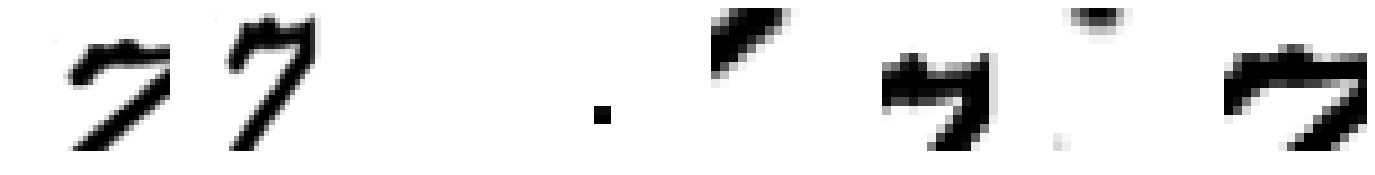

In [ ]:
axes = learn.swav.show_one()

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(8.7588)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01 - augmentations.ipynb.
Converted 02 - layers.ipynb.
Converted 03 - distributed.ipynb.
Converted 10 - simclr.ipynb.
Converted 11 - moco.ipynb.
Converted 12 - byol.ipynb.
Converted 13 - swav.ipynb.
Converted 20 - clip.ipynb.
Converted 21 - clip-moco.ipynb.
Converted index.ipynb.
